Check Python version

In [1]:
!python --version

Python 3.10.9


Import libraries

In [2]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Air Quality and Temperature Data

This dataset pertains to air quality and temperature data. It was taken from the UCI Machine Learning Repository: [UCI ML Repository](https://archive.ics.uci.edu/ml/index.php)


In [3]:
file_name = 'air_quality.csv'

In [4]:
dataset = pd.read_csv(file_name)

In [5]:
dataset=dataset.head(500)
dataset.shape

(500, 14)

In [6]:
dataset.columns

Index(['datetime', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'RH', 'AH', 'T'],
      dtype='object')

In [7]:
dataset.head()

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
0,10-03-2004 18:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,48.9,0.7578,13.6
1,10-03-2004 19:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,47.7,0.7255,13.3
2,10-03-2004 20:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,54.0,0.7502,11.9
3,10-03-2004 21:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,60.0,0.7867,11.0
4,10-03-2004 22:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,59.6,0.7888,11.2


In [8]:
dataset.tail()

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T
495,31-03-2004 09:00,2.2,1262,216,8.6,924,181,872,125,1576,1093,74.4,0.9384,10.4
496,31-03-2004 10:00,1.7,1197,117,6.5,837,144,957,118,1498,965,71.0,0.9582,11.5
497,31-03-2004 11:00,1.9,1277,156,7.7,886,140,902,109,1579,1004,70.0,0.9924,12.2
498,31-03-2004 12:00,2.9,1430,332,11.3,1025,204,779,123,1772,1166,73.3,1.0442,12.3
499,31-03-2004 13:00,2.2,1242,232,9.1,944,149,846,114,1638,991,78.1,1.0411,11.3


Define the required time and target columns

In [9]:
time_col = dataset.columns[0]
dataset[time_col] = pd.to_datetime(dataset[time_col], format="%d-%m-%Y %H:%M", errors='coerce')
time_col = dataset.columns[0]
target_col = dataset.columns[-1]
dataset[time_col] = dataset[time_col].astype(str)

Change target column to float

In [10]:
# dataset[target_col] = dataset[target_col].astype(float)

In [11]:
# dataset.head()

Split dataset into train and test sets

In [12]:
train_size = 0.9
train_points = int(train_size*len(dataset))
train_df = dataset.iloc[:train_points]
test_df = dataset.iloc[train_points:]

Plot graph

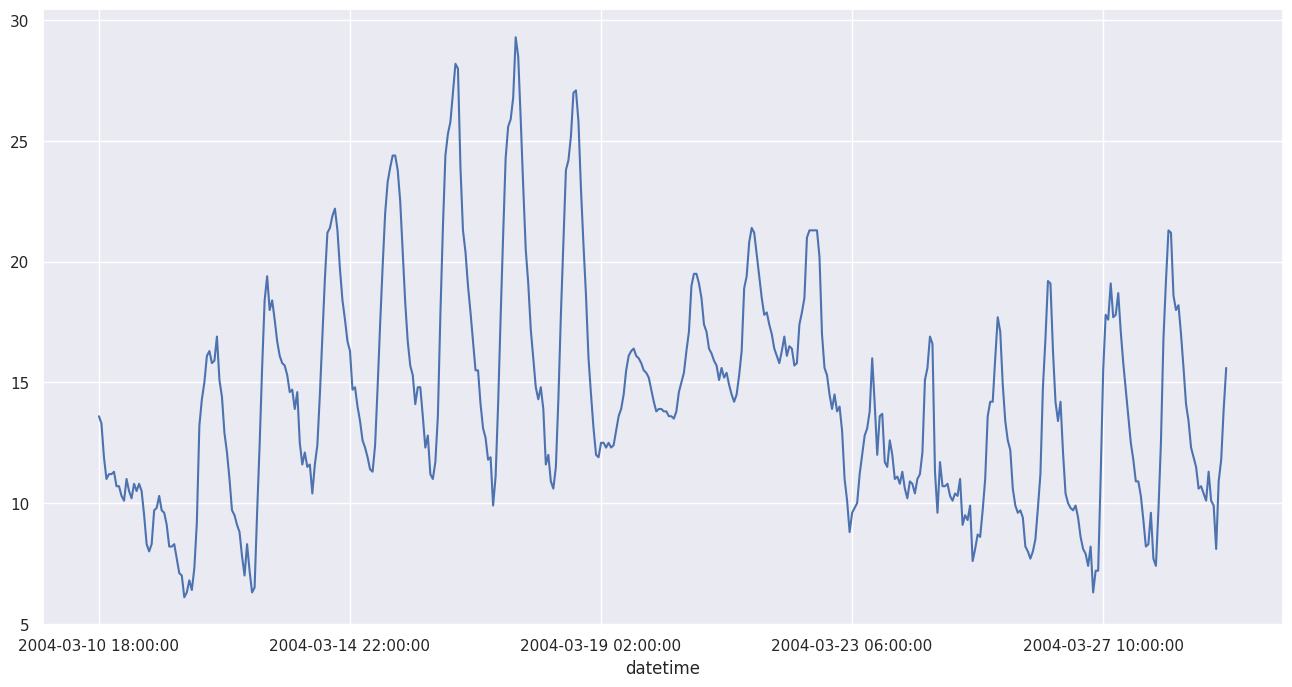

In [13]:
figsize = (16, 8)
train_df.set_index(time_col)[target_col].plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [14]:
train_data = []
for value in train_df.values:
    train_data.append(list(value))

In [15]:
train_data[:2]

[['2004-03-10 18:00:00',
  2.6,
  1360,
  150,
  11.9,
  1046,
  166,
  1056,
  113,
  1692,
  1268,
  48.9,
  0.7578,
  13.6],
 ['2004-03-10 19:00:00',
  2.0,
  1292,
  112,
  9.4,
  955,
  103,
  1174,
  92,
  1559,
  972,
  47.7,
  0.7255,
  13.3]]

Custom Model Request (optional)

In [16]:
# Default model request

# # Customized model request
model_request = {
    'type': 'meta_wa',  # 'meta_naive', 'meta_wa'
    'scorers': ['mase', 'smape'],
    'params': {
        'preprocessors': [
            # {'type': 'dartsimputer'},
            # {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            # {'type': 'darts_rnn',
            #  'params': {
            #      'model': 'LSTM',
            #      'hidden_dim': 10,
            #      'n_rnn_layers': 3
            # }},
            {'type': 'darts_nhits',
             'params': {
                 'output_chunk_length': 24,
                 'input_chunk_length': 24,                 
                 'n_epochs': 50,
            }},
            #     {'type': 'darts_rnn',
            #  'params': {
            #      'model': 'LSTM',
            #      'hidden_dim': 10,
            #      'n_rnn_layers': 3
            # }},
            {'type': 'darts_nlinear'},
            {'type': 'darts_dlinear'},
            #  {'type': 'darts_blockrnn'},
        ],
    },
}

This is for JSON model_request

In [17]:
# file_path = 'model_request.json'
# # For writing the model request to a json file
# with open(file_path, 'r') as file:
#     model_request = json.load(file)

This is for YAML model_request

In [18]:
# file_path = 'model_request.yaml'
# # For reading the model request from a yaml file
# with open(file_path, 'r') as file:
#     model_request = yaml.safe_load(file)

Train API JSON Payload

In [19]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [20]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [21]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [22]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [23]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 679 ms, sys: 525 ms, total: 1.2 s
Wall time: 5min 16s


In [24]:
train_json_out = response.json()  # dict output
# train_json_out

### **Forecast API**

Forecast Dates: predict the next 32 years of temperature anomaly data (1980-2012)

In [25]:
test_data = []
for value in test_df.drop(columns=target_col).values:
    test_data.append(list(value))

In [26]:
test_data[:2]

[['2004-03-29 12:00:00',
  1.4,
  971,
  91,
  5.5,
  786,
  92,
  1129,
  78,
  1272,
  546,
  29.0,
  0.5406],
 ['2004-03-29 13:00:00',
  1.6,
  1010,
  146,
  6.5,
  833,
  91,
  1070,
  83,
  1332,
  561,
  27.9,
  0.5517]]

Model from Train API

In [27]:
model = train_json_out['model']

Forecast API JSON Payload

In [28]:
api_json = {
    'model': model,
    'data': test_data
}

Build URL (same as train except for the endpoint)

In [29]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [30]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 167 ms, sys: 40.9 ms, total: 208 ms
Wall time: 9.79 s


In [31]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['2004-03-29 12:00:00', 16.813435235823313],
  ['2004-03-29 13:00:00', 16.881765573558724],
  ['2004-03-29 14:00:00', 16.507462361995884],
  ['2004-03-29 15:00:00', 16.222437072119412],
  ['2004-03-29 16:00:00', 15.859298569438554],
  ['2004-03-29 17:00:00', 15.128357706950798],
  ['2004-03-29 18:00:00', 14.150706855135207],
  ['2004-03-29 19:00:00', 13.294171783874038],
  ['2004-03-29 20:00:00', 12.675919530062382],
  ['2004-03-29 21:00:00', 12.214814413095944],
  ['2004-03-29 22:00:00', 11.740640840827524],
  ['2004-03-29 23:00:00', 11.201212558124514],
  ['2004-03-30 00:00:00', 10.838942006194333],
  ['2004-03-30 01:00:00', 10.479214594474698],
  ['2004-03-30 02:00:00', 10.25089462682822],
  ['2004-03-30 03:00:00', 10.254583413895556],
  ['2004-03-30 04:00:00', 10.549151286115405],
  ['2004-03-30 05:00:00', 10.622641646971928],
  ['2004-03-30 06:00:00', 10.516986570265555],
  ['2004-03-30 07:00:00', 10.863778623049736],
  ['2004-03-30 08:00:00', 11.75361394320689],
  ['200

Combine forecast dates and output

In [32]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [33]:
forecast_df.shape

(50, 2)

In [34]:
forecast_df.columns

Index(['datetime', 'T'], dtype='object')

In [35]:
forecast_df.head()

,datetime,T
0,2004-03-29 12:00:00,16.813435
1,2004-03-29 13:00:00,16.881766
2,2004-03-29 14:00:00,16.507462
3,2004-03-29 15:00:00,16.222437
4,2004-03-29 16:00:00,15.859299


In [36]:
forecast_df.tail()

,datetime,T
45,2004-03-31 09:00:00,13.410235
46,2004-03-31 10:00:00,14.680413
47,2004-03-31 11:00:00,15.702464
48,2004-03-31 12:00:00,16.444088
49,2004-03-31 13:00:00,16.826416


Plot train and forecast side-by-side

/tmp/ipykernel_7494/2998340865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['color'] = 'b'


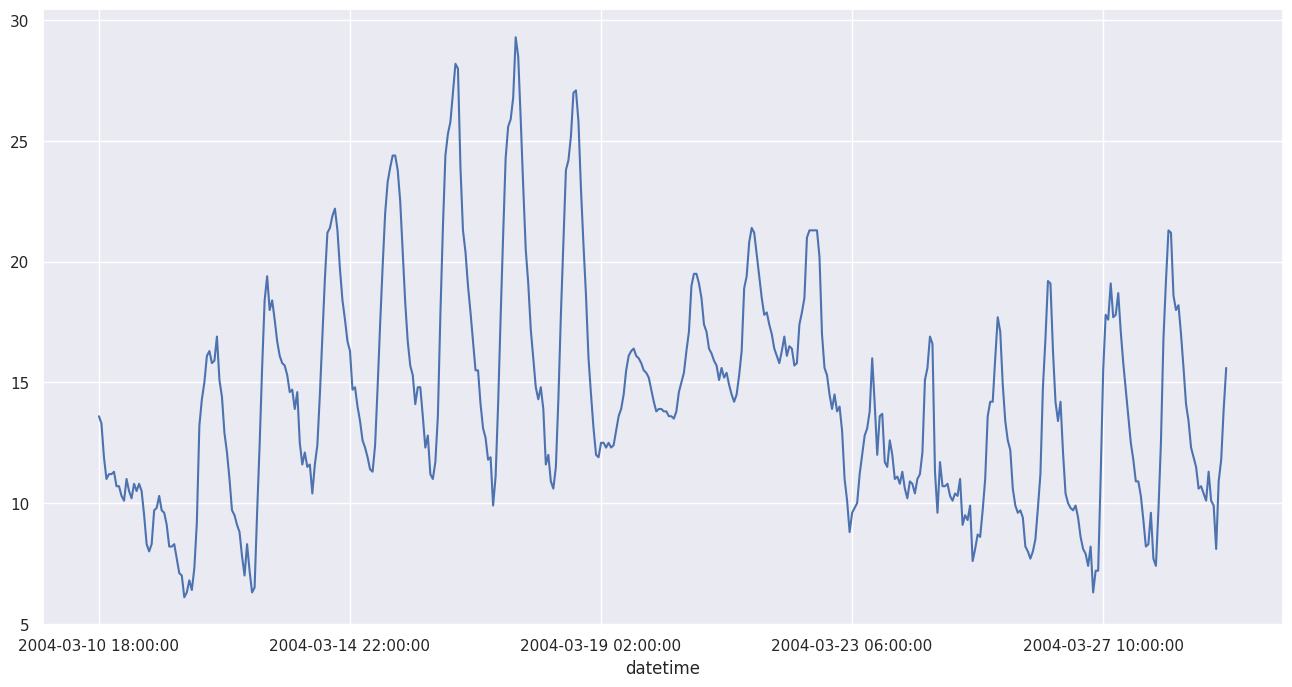

In [37]:
train_df['color'] = 'b'
train_df.set_index(time_col)[target_col].plot(figsize=figsize, color=train_df['color']);

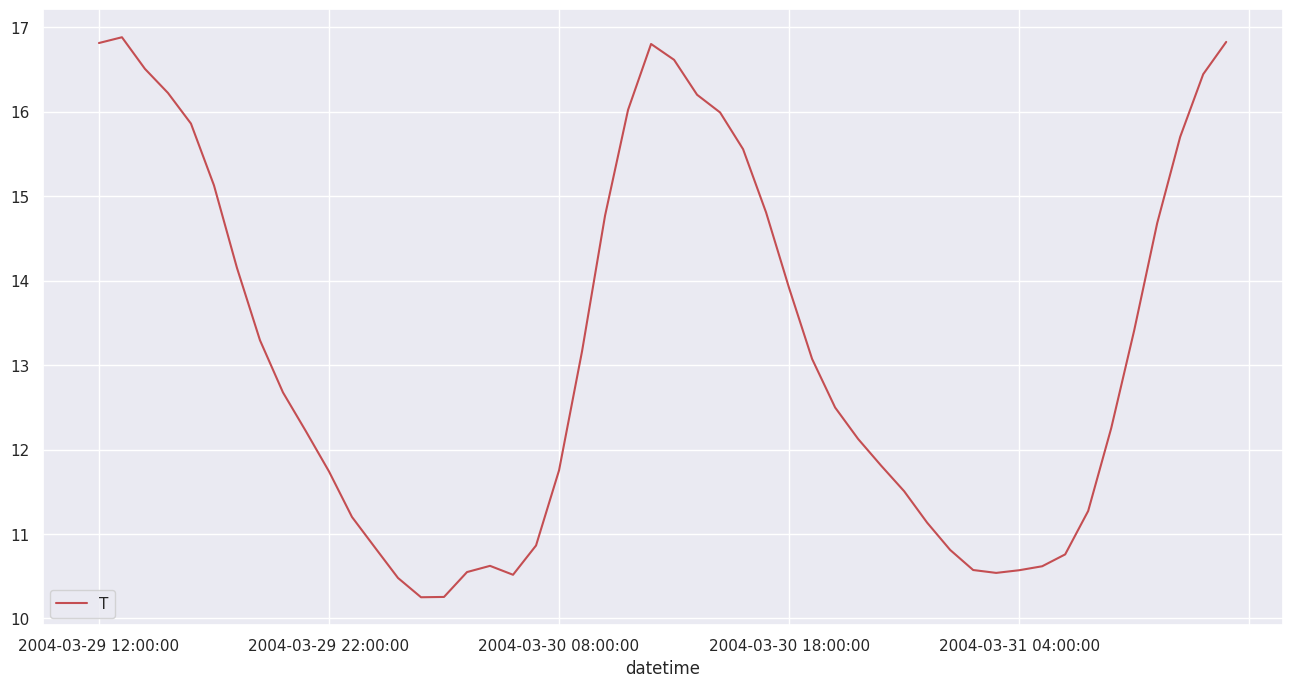

In [38]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and forecast sets

In [39]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [40]:
df.shape

(500, 15)

In [41]:
df.head()

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T,color
0,2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578,13.6,b
1,2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255,13.3,b
2,2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502,11.9,b
3,2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867,11.0,b
4,2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888,11.2,b


In [42]:
df.tail()

,datetime,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,T,color
495,2004-03-31 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.410235,r
496,2004-03-31 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.680413,r
497,2004-03-31 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.702464,r
498,2004-03-31 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.444088,r
499,2004-03-31 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.826416,r


Plot combined train and forecast sets with the vertical black line as the cut-off

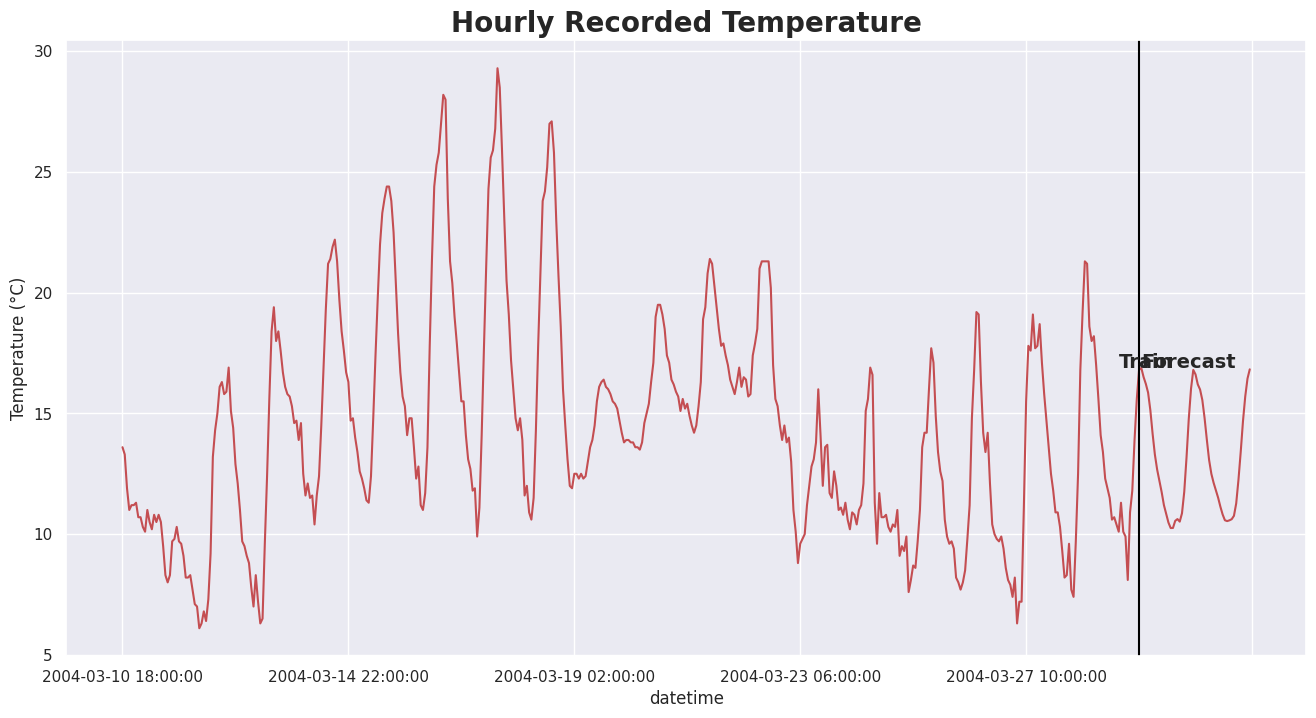

In [43]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
plt.axvline(x=len(train_df), color='black', label='Train/Forecast set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Forecast', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Temperature (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Hourly Recorded Temperature', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset to compare

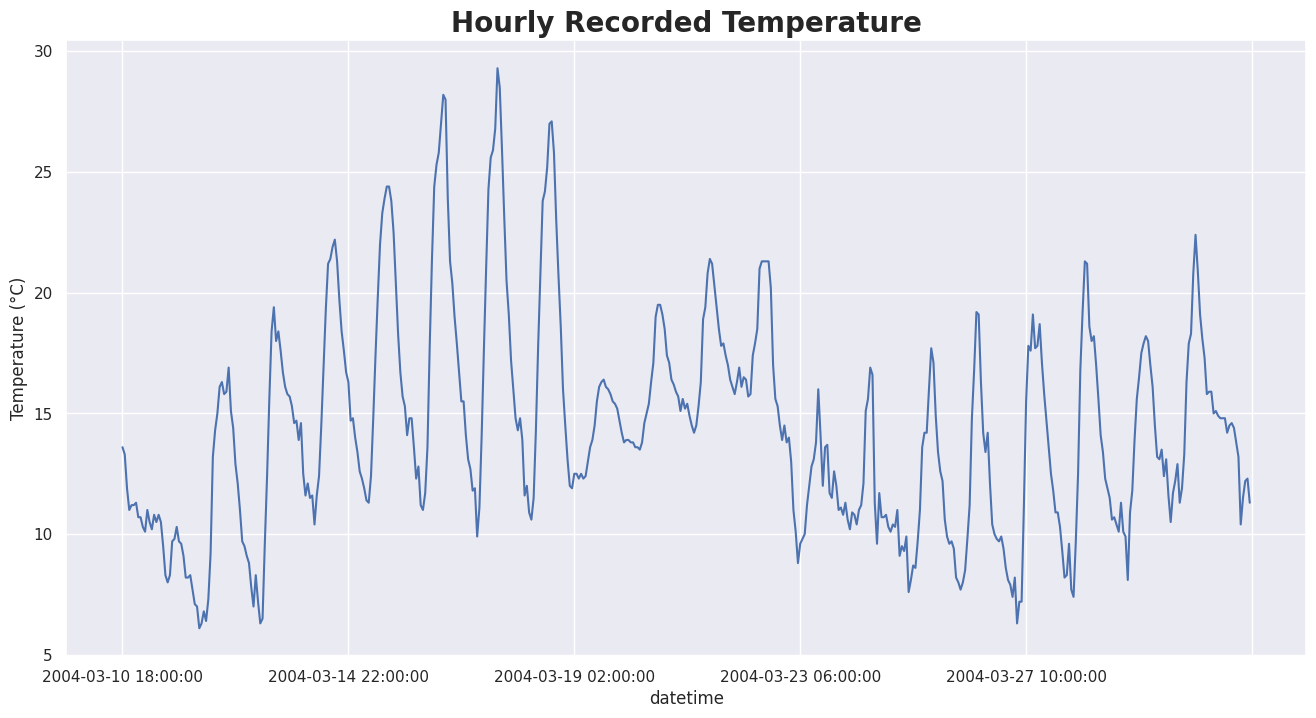

In [44]:
figsize = (16, 8)
dataset.set_index(time_col)[target_col].plot(figsize=figsize);
plt.ylabel(ylabel='Temperature (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Hourly Recorded Temperature', fontweight='bold', fontsize=20)
plt.show();

Plot original dataset (blue) with SYBIL forecasted values (red)

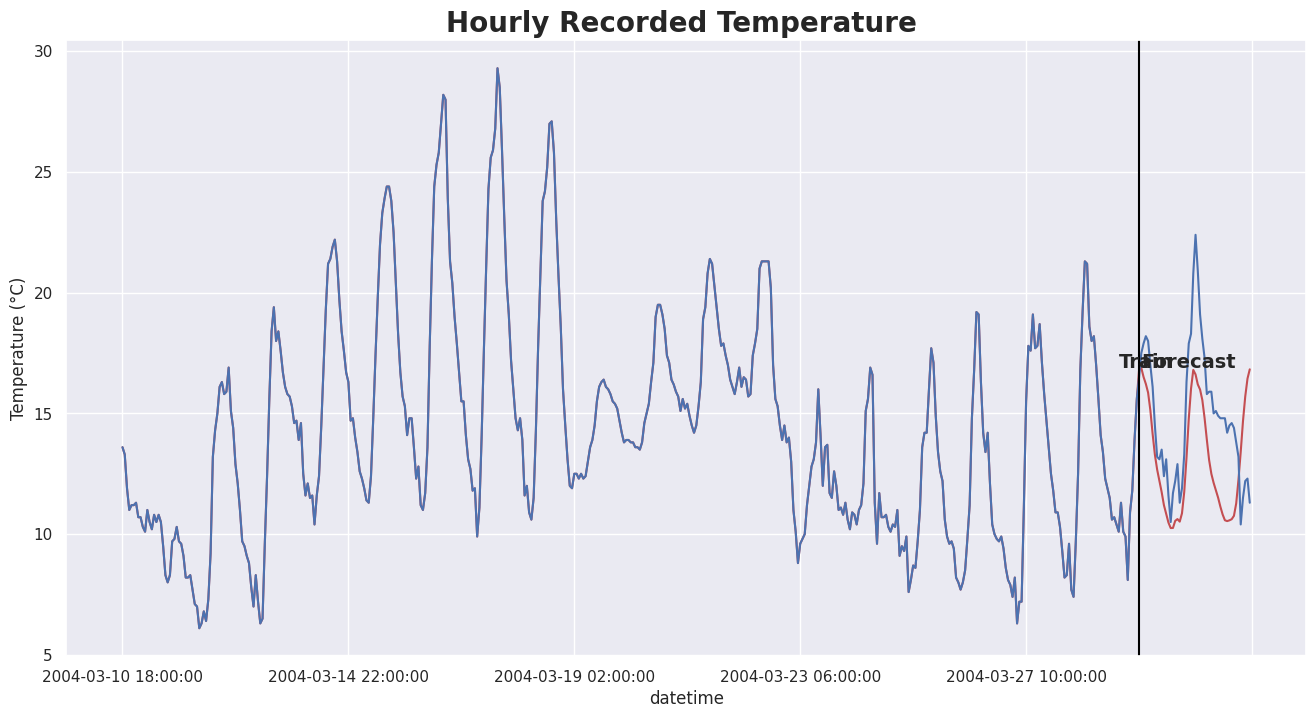

In [45]:
df.set_index(time_col)[target_col].plot(figsize=figsize, color='r')
dataset.set_index(time_col)[target_col].plot(figsize=figsize);
plt.axvline(x=len(train_df), color='black', label='Train/Forecast set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Forecast', fontweight='bold', fontsize=14)
plt.ylabel(ylabel='Temperature (' + u'\N{DEGREE SIGN}' + 'C)')
plt.title(label='Hourly Recorded Temperature ', fontweight='bold', fontsize=20)
plt.show();